In [2]:
import pyscf
from pyscf import dft, pbc
from pyscf.pbc import gto, scf
import numpy as np
from pyscf import lib
from pyscf.dft import libxc
from pyscf.dft import numint
from pyscf.dft import xc_deriv
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [21]:
#Make Unit Cell
cell = gto.Cell()
cell.atom = '''H 0 0 0; H 1 1 1'''
cell.basis = 'gth-dzvp'
cell.pseudo = 'gth-pade' # LDA, gth-pbe is GGA
cell.a = [[2,0,0],[0,2,0],[0,0,2]] #edge length
cell.build()
#since H2 has no core electrons, do not need to add _ecp to account for them, pseudo already captures all the electrons

In [23]:
#To do dft calculations, need kpoints for kpoint sampling
kpts = cell.make_kpts([2,2,2]) #2,2,2 specifies how many kpoints in each direction
kmf = scf.KRHF(cell, kpts=kpts).run()
print(kmf) #Warn HOMO and LUMO are the same


WARN: HOMO 0.222950086705 == LUMO 0.222950086707

converged SCF energy = -0.986087325072073


In [29]:
mol = dft.gto.Mole()
mol.atom = '''
    H 0 0 -1
    H 0 0 1
'''
mol.basis = 'gth-dzvp'
mol.symmetry = True
mol.build()
mylda = dft.RKS(mol)
mylda.xc = 'lda,vwn'
mylda.kernel()

converged SCF energy = -0.964906405121211


np.float64(-0.9649064051212111)

In [95]:
#Example 2: Diamond
cell = gto.Cell()
cell.atom = '''
    C 0.0000 0.0000 0.0000
    C 0.8917 0.8917 0.8917
'''
cell.a = '''
    0.0000 1.7834 1.7834
    1.7834 0.0000 1.7834
    1.7834 1.7834 0.0000
'''
cell.basis = 'gth-szv'
cell.pseudo = 'gth-pade' #ecp included implicitely
cell.build()

In [43]:
kpts = cell.make_kpts([2,2,2])
kmf = scf.KRHF(cell, kpts=kpts).run()

converged SCF energy = -10.9308583552715


In [111]:
#Band Structure calculations
#the argument 'kpts' is a list along which band structure is desired
import pyscf.pbc.tools
from pyscf.pbc.tools.lattice import get_bandpath_fcc

#steps to doing band structure calculations
#1. Build cell
#2. Run SCF calculation w/ kpts
#3. generate a path for the band structure by making a list of points where you want to calculate
#4. calc band energies along k-path
#5. plot 

In [119]:
#Manually find kpt list from Brillouin Zone Critical Points for fcc
points = {
    'G': [0.0,0.0,0.0],
    'X': [0.5,0.0,0.5],
    'W': [0.5,0.25,0.75],
    'K': [0.375, 0.375, 0.75],
    'L': [0.5, 0.5, 0.5],
    'U': [0.625, 0.25, 0.625]
}
path = ['G', 'X', 'W', 'K', 'G', 'L', 'U'] #doi: 10.1016/j.commatsci.2010.05.010
npoints = 50 #number of points in each segment of the path
band_kpts = [] #manually make a list, since idk the function
kpath = [] #distances for x-axis in band plot
sp_points=[0] #positions of critical points (path benchmarks)

for i in range(len(path)-1):
    beginning = np.array(points[path[i]]) #ID start of current segment
    end = np.array(points[path[i+1]]) #ID end of current segment, since goes  G -> X, etc
    
    #need to create evenly spaced points in each segment
    for j in np.linspace(0, 1, npoints, endpoint=False): #start, stop, points, include stop value?
        band_kpts.append((1-j)*beginning + j*end)
    #kpath and sp_points
    for k in range(npoints):
        if i==0 and k==0:
            kpath.append(0.0)
        else:
            x = np.linalg.norm(end-beginning) / npoints
            kpath.append(kpath[-1] + x)
    sp_points.append(len(band_kpts))
    
band_kpts.append(points[path[-1]]) #need to add last value, since loop is j-1
band_kpts = np.array(band_kpts)
band_kpts = cell.get_abs_kpts(band_kpts) #convert to absolute k-space
kpath.append(kpath[-1] + np.linalg.norm(end-beginning)/npoints)

In [105]:
#Calculate band energies along the path
import pyscf.pbc.dft as pbcdft
mf = pbcdft.RKS(cell)
print(mf.kernel(), "Hartree")
#get band energies (orbital energies)
e_kn = mf.get_bands(band_kpts)[0] #eigenvalues at [0], eigenvectors at [1]
#Valence band maximum (vbm)
#find the highest occupied orbital energy across all k points
vbmax = -99
for i in e_kn: #e_kn is a list of arrays, each entry = k-point, each array = orbital energies at that k-point
    vb_k = i[cell.nelectron//2-1] #occupied energy at that k-point
    if vb_k > vbmax:
        vbmax = vb_k #update to get highest value as it loops
#Align bands to vbm so vbm = 0 eV >> makes plot look better
e_kn = [i-vbmax for i in e_kn]


converged SCF energy = -10.2213461227583
-10.221346122758343 Hartree


kpath [0.0, np.float64(0.01414213562373095), np.float64(0.0282842712474619), np.float64(0.042426406871192854), np.float64(0.0565685424949238), np.float64(0.07071067811865475), np.float64(0.08485281374238571), np.float64(0.09899494936611666), np.float64(0.11313708498984762), np.float64(0.12727922061357858)] ... [np.float64(3.2650752117730937), np.float64(3.2711989361300517), np.float64(3.27732266048701), np.float64(3.283446384843968), np.float64(3.289570109200926), np.float64(3.295693833557884), np.float64(3.301817557914842), np.float64(3.3079412822718), np.float64(3.3140650066287582), np.float64(3.3201887309857163)]
sp_points: [0, 50, 100, 150, 200, 250, 300]
kpath length (301,)


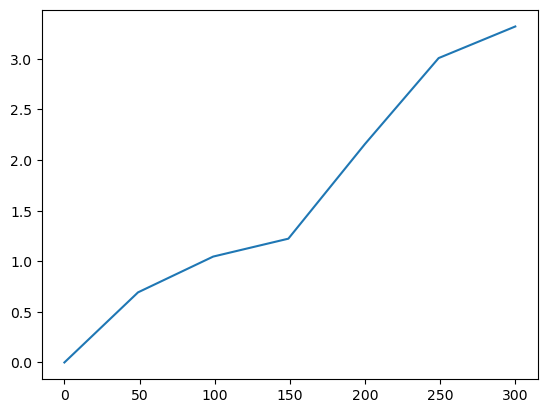

In [235]:
print('kpath', kpath[:10], '...', kpath[-10:])
print('sp_points:', sp_points)
print('kpath length', np.shape(kpath))
#print(e_kn[:,0])
#print('\n', e_kn[0])
plt.plot(kpath)
plt.show()

(301, 8)
301


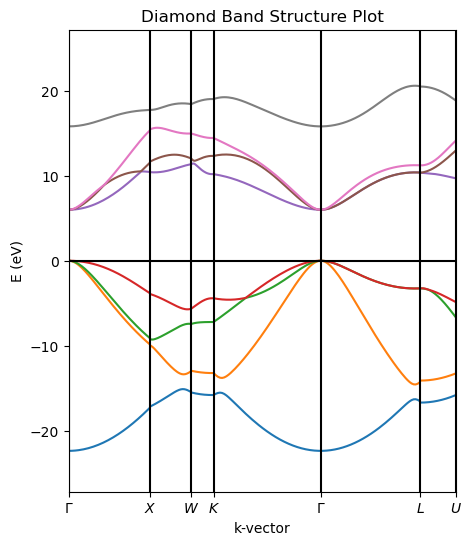

In [243]:
#plot band structures
#commonly plotted with eV - need to convert from hartree
conversion = 27.21139 #eV in a Hartree
#Energy window
emin = -1*conversion
emax = 1*conversion
e_kn = np.array(e_kn)
print(np.shape(e_kn))
sp_points_kpath = [kpath[i] for i in sp_points]
e_kn_ev = e_kn * conversion
#Plot
plt.figure(figsize=(5,6))
nbands = cell.nao_nr() #number of atomic orbitals in the unit cell = number KS bands
print(len(band_kpts))
for i in range(nbands):
    #plt.plot(kpath, [e[i]*conversion for e in e_kn]) #extracts energy of band at each k-point
    plt.plot(kpath, e_kn_ev[:, i])
    #for e in e_kn[i]:
        #pt = e_kn[i][e] * conversion
        #plt.plot(kpath, pt)
for k in sp_points_kpath:
    plt.plot([k,k], [emin, emax], 'k-') #make indexes on graph
plt.plot([0, sp_points_kpath[-1]], [0,0], 'k-') #mark vbm reference level at 0 eV
plt.xticks(sp_points_kpath, ['$%s$' % i for i in [r'\Gamma', 'X', 'W', 'K', r'\Gamma', 'L', 'U']])
plt.axis(xmin=0, xmax=sp_points_kpath[-1], ymin=emin, ymax=emax)
plt.xlabel('k-vector')
plt.title("Diamond Band Structure Plot")
plt.ylabel("E (eV)")
plt.show()